# Library import

In [7]:
from pySembrane.simulator import MembraneProc

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.interpolate import interp1d

from scipy.optimize import minimize
from scipy import interpolate

parameters = {'axes.labelsize': 17,
              'xtick.labelsize': 16,
              'ytick.labelsize': 16,
          'axes.titlesize': 20}
plt.rcParams.update(parameters)
plt.rcParams['font.family'] = 'arial'

from itertools import product

from sklearn.metrics import r2_score

# Validation

## Scenario 1.

In [8]:
# Operating conditions
P_feed = 35                # pressure of feed side (bar)
T = 308
F_feed = 0.35
y_feed = np.array([0.1, 0.9])     # mole fraction (CO2, CH4)
Ff_z0_init = list(y_feed*F_feed)

n_stg = 1
mode = 'P2F'

# Sizing parameters
D_inner = 200*1e-3            # Membrane inner diameter (mm)
D_outer = 250*1e-3            # Membrane outer diameter (mm)
thickness = (D_outer-D_inner)/2
D_module = 0.1*1e3            # Module diameter (mm)
N_fiber = 60000               # number of fiber (-)
L = 0.6*1e3                   # fiber length (mm)
Ac_shell = np.pi*D_module**2/4 - N_fiber*np.pi*D_inner**2/4     # (mm^2)
config = 'COFS'

# Gas properties
Mw_i = np.array([44e-3, 16e-3])     # Molar weight (kg/mol)
rho_i = np.array([1.98, 0.657])*1e-9     # Density (kg/mm3)
mu_H2 = 0.0155e-3           # CO2 viscosity (Pa s)
mu_N2 = 0.011e-3           # CH4 viscosity (Pa s)
# viscosity values from https://www.engineeringtoolbox.com/gases-absolute-dynamic-viscosity-d_1888.html
mu_i = np.array([mu_H2, mu_N2])

k_mass = 1e-1               # Mass transfer coeff. (mm/s)

# Constants
Rgas = 8.314*1e9                # mm3 Pa/K mol

N = 400
z_dom = np.linspace(0,L,N+1)
a_perm = np.array([3.207e-9, 1.33e-10])*1e-6*1e5     #Permeance(mol/(mm2 bar s))

[3.50000000e-02 3.15000000e-01 4.34319713e-05 5.20126427e-06
 3.50000000e+01 1.01000000e+00]
Simulation started
Simulation is completed without warning
Mass balance (error %):  1.1099388279205262e-13


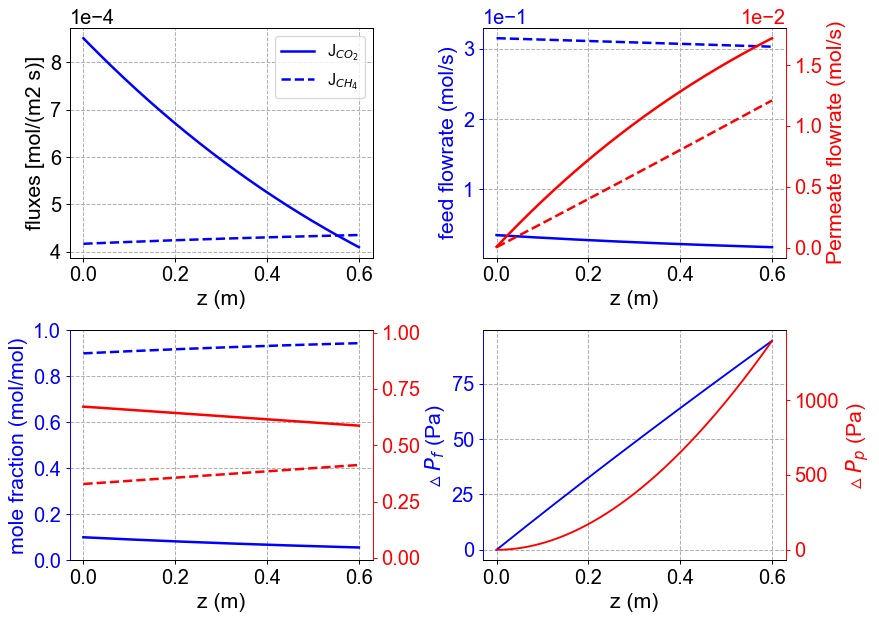

In [9]:
n_component = 2
mem = MembraneProc(config, L, D_module, N_fiber, 
            n_component, n_node = N)
mem.membrane_info(a_perm, D_inner, D_outer)
mem.gas_prop_info(Mw_i, mu_i, rho_i)
mem.mass_trans_info(k_mass)
mem.boundaryC_info(y_feed, P_feed, F_feed, T)
mem.initialC_info()
print(mem._y0)
#single
res = mem.run_mem(cp=True, cp_cond = [1, 298])
err = mem.MassBalance()

mem.PlotResults(component=['{CO_2}', '{CH_4}'])

In [10]:
def ValidateLit(res, configuration):
    n_comp = int((res.shape[-1]-2)/2)
    
    if configuration[:2] == 'CO':
        F_p_tot = sum(res[-1,n_comp:n_comp*2])
        Pu_CO2 = res[-1,n_comp]/F_p_tot
        
        F_r_tot = sum(res[-1,:n_comp])
        Pu_CH4 = res[-1,1]/F_r_tot
        
    elif configuration[:2] == 'CT':
        F_p_tot = sum(res[0,n_comp:n_comp*2])
        Pu_CO2 = res[0,n_comp]/F_p_tot
        
        F_r_tot = sum(res[-1,:n_comp])
        Pu_CH4 = res[-1,1]/F_r_tot
    
    res_idx = ['Permeate flow',
               'Permeate CO2 purity',
               'Retentate flow',
               'Retentate CH4 purity']
    
    val_res = pd.DataFrame([F_p_tot,Pu_CO2*100,F_r_tot,Pu_CH4*100],index=res_idx).T
    return val_res

In [9]:
s1 = ValidateLit(res, config)
s1

,Permeate flow,Permeate CO2 purity,Retentate flow,Retentate CH4 purity
0,0.029316,58.725602,0.320774,94.437148


## Scenario 2.

In [10]:
# Operating conditions
P_feed = 35                # pressure of feed side (bar)
T = 308
F_feed = 0.35
y_feed = np.array([0.1, 0.9])     # mole fraction (CO2, CH4)
Ff_z0_init = list(y_feed*F_feed)

n_stg = 1
mode = 'P2F'

# Sizing parameters
D_inner = 200*1e-3            # Membrane inner diameter (mm)
D_outer = 250*1e-3            # Membrane outer diameter (mm)
thickness = (D_outer-D_inner)/2
D_module = 0.1*1e3            # Module diameter (mm)
N_fiber = 60000               # number of fiber (-)
L = 0.6*1e3                   # fiber length (mm)
Ac_shell = np.pi*D_module**2/4 - N_fiber*np.pi*D_inner**2/4     # (mm^2)
config = 'CTFS'

# Gas properties
Mw_i = np.array([44e-3, 16e-3])     # Molar weight (kg/mol)
rho_i = np.array([1.98, 0.657])*1e-9     # Density (kg/mm3)
mu_H2 = 0.0155e-3           # CO2 viscosity (Pa s)
mu_N2 = 0.011e-3           # CH4 viscosity (Pa s)
# viscosity values from https://www.engineeringtoolbox.com/gases-absolute-dynamic-viscosity-d_1888.html
mu_i = np.array([mu_H2, mu_N2])

k_mass = 1e-1               # Mass transfer coeff. (mm/s)

# Constants
Rgas = 8.314*1e9                # mm3 Pa/K mol

N = 400
z_dom = np.linspace(0,L,N+1)
a_perm = np.array([3.207e-9, 1.33e-10])*1e-6*1e5     #Permeance(mol/(mm2 bar s))

[3.50000000e-02 3.15000000e-01 1.73049807e-02 2.07717051e-03
 3.50000000e+01 1.00000000e+00]
Simulation started
Simulation is completed without warning
Mass balance (error %):  4.757277092646697e-14


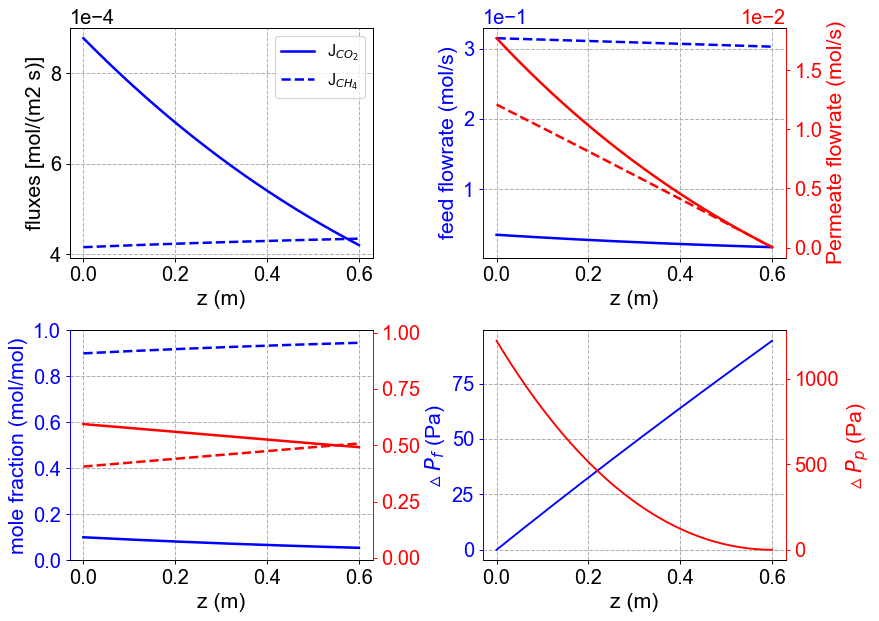

In [11]:
n_component = 2
mem = MembraneProc(config, L, D_module, N_fiber, 
            n_component, n_node = N)
mem.membrane_info(a_perm, D_inner, D_outer)
mem.gas_prop_info(Mw_i, mu_i, rho_i)
mem.mass_trans_info(k_mass)
mem.boundaryC_info(y_feed, P_feed, F_feed, T)
mem.initialC_info()
print(mem._y0)
#single
res = mem.run_mem(cp=True, cp_cond = [1, 298])
err = mem.MassBalance()

mem.PlotResults(component=['{CO_2}', '{CH_4}'])

In [12]:
s2 = ValidateLit(res, config)
s2

,Permeate flow,Permeate CO2 purity,Retentate flow,Retentate CH4 purity
0,0.029772,59.42289,0.320288,94.586647


## Scenario 3.

In [13]:
# Operating conditions
P_feed = 15                # pressure of feed side (bar)
T = 308
F_feed = 0.35
y_feed = np.array([0.1, 0.9])     # mole fraction (CO2, CH4)
Ff_z0_init = list(y_feed*F_feed)

# Sizing parameters
D_inner = 120*1e-3            # Membrane inner diameter (mm)
D_outer = 170*1e-3            # Membrane outer diameter (mm)
thickness = (D_outer-D_inner)/2
D_module = 0.05*1e3            # Module diameter (mm)
N_fiber = 60000               # number of fiber (-)
L = 1.5*1e3                   # fiber length (mm)
Ac_shell = np.pi*D_module**2/4 - N_fiber*np.pi*D_inner**2/4     # (mm^2)
config = 'CTFS'

# Gas properties
Mw_i = np.array([44e-3, 16e-3])     # Molar weight (kg/mol)
rho_i = np.array([1.98, 0.657])*1e-9     # Density (kg/mm3)
mu_H2 = 0.0155e-3           # CO2 viscosity (Pa s)
mu_N2 = 0.011e-3           # CH4 viscosity (Pa s)
# viscosity values from https://www.engineeringtoolbox.com/gases-absolute-dynamic-viscosity-d_1888.html
mu_i = np.array([mu_H2, mu_N2])

k_mass = 1e-1               # Mass transfer coeff. (mm/s)

# Constants
Rgas = 8.314*1e9                # mm3 Pa/K mol

N = 400
z_dom = np.linspace(0,L,N+1)
a_perm = np.array([3.207e-9, 1.33e-10])*1e-6*1e5     #Permeance(mol/(mm2 bar s))

[3.500e-02 3.150e-01 1.750e-03 1.575e-02 1.500e+01 1.000e+00]
Simulation started
Mass balance (error %):  4.758535776594899e-14


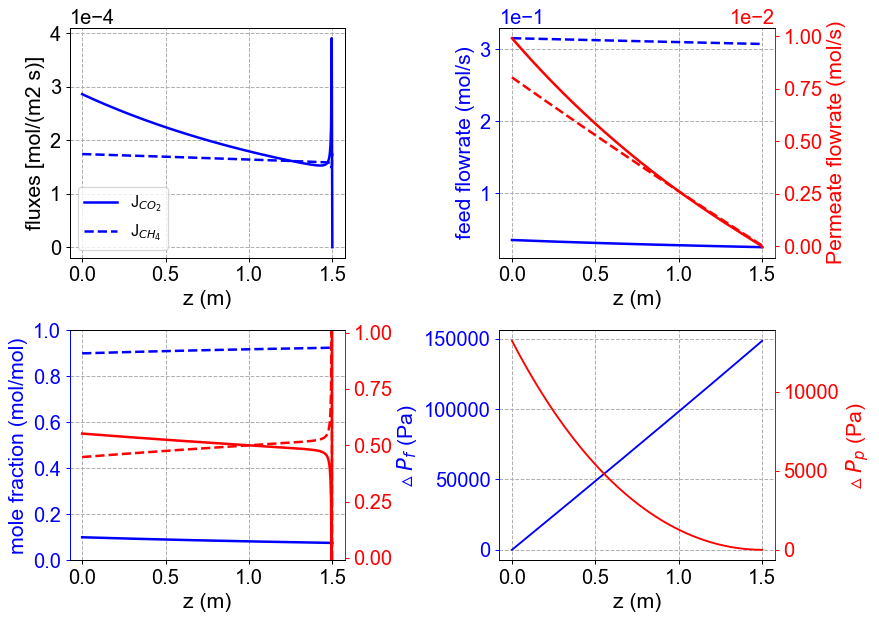

In [15]:
n_component = 2
mem = MembraneProc(config, L, D_module, N_fiber, 
            n_component, n_node = N)
mem.membrane_info(a_perm, D_inner, D_outer)
mem.gas_prop_info(Mw_i, mu_i, rho_i)
mem.mass_trans_info(k_mass)
mem.boundaryC_info(y_feed, P_feed, F_feed, T)
mem.initialC_info(on=False)
print(mem._y0)
#single
res = mem.run_mem(cp=True, cp_cond = [1, 298])
err = mem.MassBalance()

mem.PlotResults(component=['{CO_2}', '{CH_4}'])

In [16]:
s3 = ValidateLit(res, config)
s3

,Permeate flow,Permeate CO2 purity,Retentate flow,Retentate CH4 purity
0,0.017931,55.206426,0.332037,92.456769


## Scenario 4.

In [ ]:
# Operating conditions
P_feed = 5                # pressure of feed side (bar)
T = 298
F_feed = 3.718e-4
y_feed = np.array([0.1, 0.9])     # mole fraction (CO2, CH4)
Ff_z0_init = list(y_feed*F_feed)

n_stg = 1
mode = 'P2F'

# Sizing parameters
D_inner = 126*1e-3            # Membrane inner diameter (mm)
D_outer = 180*1e-3            # Membrane outer diameter (mm)
thickness = (D_outer-D_inner)/2
D_module = 0.024*1e3            # Module diameter (mm)
N_fiber = 2805               # number of fiber (-)
L = 0.8*1e3                   # fiber length (mm)
Ac_shell = np.pi*D_module**2/4 - N_fiber*np.pi*D_inner**2/4     # (mm^2)
config = 'CTFS'

# Gas properties
Mw_i = np.array([44e-3, 16e-3])     # Molar weight (kg/mol)
rho_i = np.array([1.98, 0.657])*1e-9     # Density (kg/mm3)
mu_H2 = 0.0155e-3           # CO2 viscosity (Pa s)
mu_N2 = 0.011e-3           # CH4 viscosity (Pa s)
# viscosity values from https://www.engineeringtoolbox.com/gases-absolute-dynamic-viscosity-d_1888.html
mu_i = np.array([mu_H2, mu_N2])

k_mass = 1e-1               # Mass transfer coeff. (mm/s)

# Constants
Rgas = 8.314*1e9                # mm3 Pa/K mol

N = 400
z_dom = np.linspace(0,L,N+1)
a_perm = np.array([1.749e-9, 1.227e-10])*1e-6*1e5     #Permeance(mol/(mm2 bar s))

[3.71800000e-05 3.34620000e-04 1.50194718e-04 1.83803428e-05
 5.00000000e+00 1.00000000e+00]
Simulation started
Mass balance (error %):  2.5235071112877717e-13


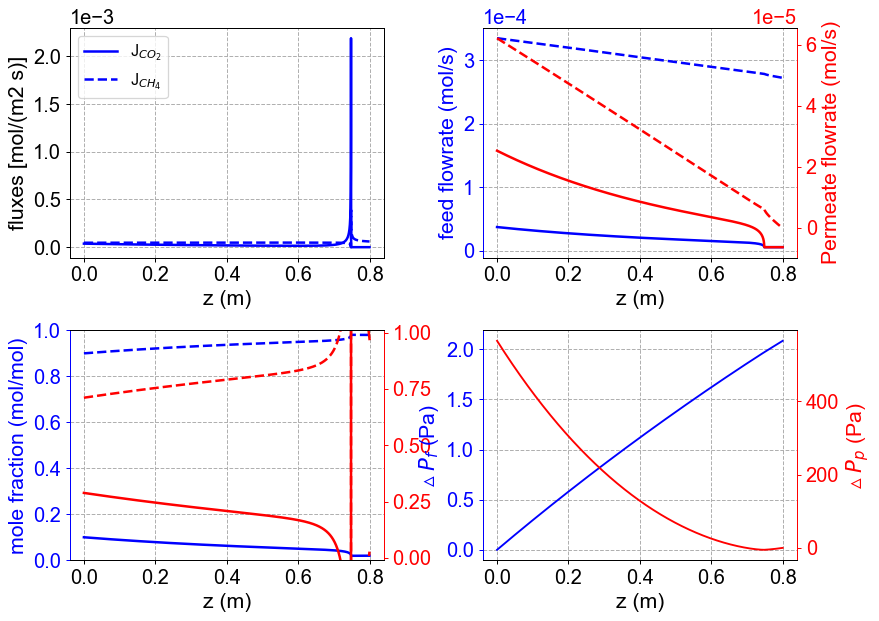

In [ ]:
n_component = 2
mem = MembraneProc(config, L, D_module, N_fiber, 
            n_component, n_node = N)
mem.membrane_info(a_perm, D_inner, D_outer,)
mem.gas_prop_info(Mw_i, mu_i, rho_i)
mem.mass_trans_info(k_mass)
mem.boundaryC_info(y_feed, P_feed, F_feed, T)
mem.initialC_info()
print(mem._y0)
#single
res = mem.run_mem(tolerance = 1e-7)
err = mem.MassBalance()

mem.PlotResults(component=['{CO_2}', '{CH_4}'])

In [ ]:
s4 = ValidateLit(res, config)
s4

,Permeate flow,Permeate CO2 purity,Retentate flow,Retentate CH4 purity
0,0.000087,28.877482,0.000278,98.020397


## Scenario 1-1. -> with sweep gas

In [ ]:
# Operating conditions
P_feed = 35                # pressure of feed side (bar)
T = 308
F_feed = 0.35
y_feed = np.array([0.1, 0.9, 0])     # mole fraction (CO2, CH4, N2)
Ff_z0_init = list(y_feed*F_feed)

n_stg = 1
mode = 'P2F'

# Sizing parameters
D_inner = 200*1e-3            # Membrane inner diameter (mm)
D_outer = 250*1e-3            # Membrane outer diameter (mm)
thickness = (D_outer-D_inner)/2
D_module = 0.1*1e3            # Module diameter (mm)
N_fiber = 60000               # number of fiber (-)
L = 0.6*1e3                   # fiber length (mm)
Ac_shell = np.pi*D_module**2/4 - N_fiber*np.pi*D_inner**2/4     # (mm^2)
config = 'CTFS'

# Gas properties
Mw_i = np.array([44e-3, 16e-3, 28e-3])     # Molar weight (kg/mol)
rho_i = np.array([1.98, 0.657, 1.1606])*1e-9     # Density (kg/mm3)
mu_CO2 = 0.0155e-3           # CO2 viscosity (Pa s)
mu_CH4 = 0.011e-3           # CH4 viscosity (Pa s)
mu_N2 = 1.89*1E-5           # N2 viscosity (Pa s)
# viscosity values from https://www.engineeringtoolbox.com/gases-absolute-dynamic-viscosity-d_1888.html
mu_i = np.array([mu_CO2, mu_CH4, mu_N2])

k_mass = 1e-1               # Mass transfer coeff. (mm/s)

# Constants
Rgas = 8.314*1e9                # mm3 Pa/K mol

N = 400
z_dom = np.linspace(0,L,N+1)
a_perm = np.array([3.207e-9, 1.33e-10, 3.968e-10])*1e-6*1e5     #Permeance(mol/(mm2 bar s))

[3.500e-02 3.150e-01 0.000e+00 1.750e-03 1.575e-02 1.750e-01 3.500e+01
 1.000e+00]
Simulation started
Mass balance (error %):  1.0572228406041301e-13


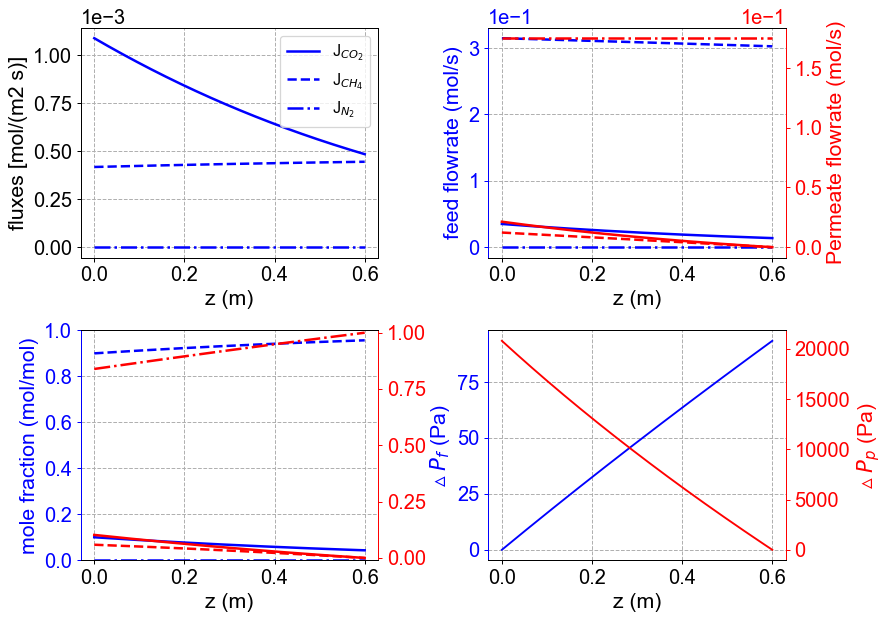

In [ ]:
n_component = 3
mem = MembraneProc(config, L, D_module, N_fiber, 
            n_component, n_node = N, sweep_gas=True)
mem.membrane_info(a_perm, D_inner, D_outer, )
mem.gas_prop_info(Mw_i, mu_i, rho_i)
mem.mass_trans_info(k_mass)
mem.boundaryC_info(y_feed, P_feed, F_feed, T, f_sweep=np.array([0, 0, 0.35/2]))
mem.initialC_info()
print(mem._y0)
#single
res = mem.run_mem()
err = mem.MassBalance()

mem.PlotResults(component=['{CO_2}', '{CH_4}', '{N_2}'])

In [ ]:
s1_1 = ValidateLit(res, config)
s1_1

,Permeate flow,Permeate CO2 purity,Retentate flow,Retentate CH4 purity
0,0.208396,0.101482,0.316604,0.956249


## Scenario 5.

In [6]:
# Operating conditions
P_feed = 5                # pressure of feed side (bar)
T = 298
F_feed = 4.464e-4
y_feed = np.array([0.4, 0.6, 0])     # mole fraction (CO2, CH4, N2)
Ff_z0_init = list(y_feed*F_feed)

# Sizing parameters
D_inner = 150*1e-3            # Membrane inner diameter (mm)
D_outer = 200*1e-3            # Membrane outer diameter (mm)
thickness = (D_outer-D_inner)/2
D_module = 0.012*1e3            # Module diameter (mm)
N_fiber = 106               # number of fiber (-)
L = 0.3*1e3                   # fiber length (mm)
Ac_shell = np.pi*D_module**2/4 - N_fiber*np.pi*D_inner**2/4     # (mm^2)
config = 'CTFS'

# Gas properties
Mw_i = np.array([44e-3, 16e-3, 28e-3])     # Molar weight (kg/mol)
rho_i = np.array([1.784, 0.648, 1.132])*1e-9     # Density (kg/mm3)
# rho_i = np.array([1.98, 0.657])*1e-9     # Density (kg/mm3)

mu_CO2 = 1.49395e-5           # CO2 viscosity (Pa s)
mu_CH4 = 1.11628e-5           # CH4 viscosity (Pa s)
mu_N2 = 1.78375*1E-5           # N2 viscosity (Pa s)


# mu_CO2 = 0.0155e-3           # CO2 viscosity (Pa s)
# mu_CH4 = 0.011e-3           # CH4 viscosity (Pa s)
# mu_N2 = 1.89*1E-5           # N2 viscosity (Pa s)
# # viscosity values from https://www.engineeringtoolbox.com/gases-absolute-dynamic-viscosity-d_1888.html
mu_i = np.array([mu_CO2, mu_CH4, mu_N2])

k_mass = 1e-1               # Mass transfer coeff. (mm/s)

# Constants
Rgas = 8.314*1e9                # mm3 Pa/K mol

N = 5000
z_dom = np.linspace(0,L,N+1)
a_perm = np.array([8.405e-9, 1.323e-10, 3.968e-10])*1e-6*1e5     #Permeance(mol/(mm2 bar s))

[1.7856e-04 2.6784e-04 0.0000e+00 8.9280e-06 1.3392e-05 2.0120e-05
 5.0000e+00 1.0000e+00]
Simulation started
Simulation is completed without warning
Mass balance (error %):  3.1573755521289815e-13


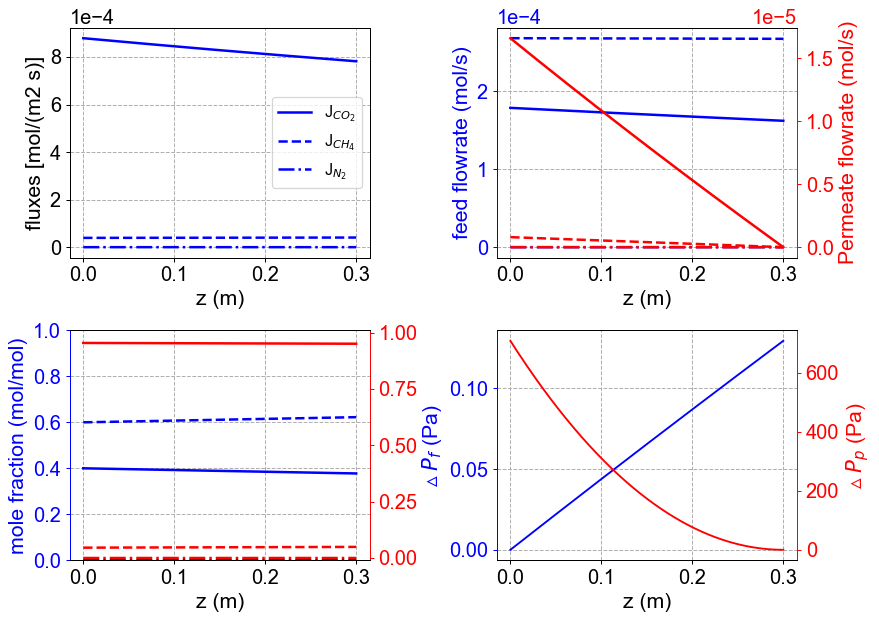

In [13]:
n_component = 3
mem = MembraneProc(config, L, D_module, N_fiber, 
            n_component, n_node = N, sweep_gas=True)
mem.membrane_info(a_perm, D_inner, D_outer, )
mem.gas_prop_info(Mw_i, mu_i, rho_i)
mem.mass_trans_info(k_mass)
mem.boundaryC_info(y_feed, P_feed, F_feed, T, f_sweep=np.array([0, 0, 2.012e-5]))
mem.initialC_info(on=False)
print(mem._y0)
#single
res = mem.run_mem(cp=False, cp_cond = [1, 298], tolerance=1e-8)
err = mem.MassBalance()

mem.PlotResults(component=['{CO_2}', '{CH_4}', '{N_2}'])

In [14]:
s5 = ValidateLit(res, config)
s5.iloc[0,0]
# s5

1.7366456311418565e-05

# Validation ==> Gu (DYCOPS)

In [29]:
# Operating conditions
P_feed = 20                # pressure of feed side (bar)
T = 313.15
F_feed = 0.03
y_feed = np.array([0.75, 0.2, 0.04, 0.01])     # mole fraction (H2, CO2, CH4, CO)
Ff_z0_init = list(y_feed*F_feed)

n_stg = 1
mode = 'P2F'

# Sizing parameters
D_inner = 200*1e-3            # Membrane inner diameter (mm)
D_outer = 250*1e-3            # Membrane outer diameter (mm)
thickness = (D_outer-D_inner)/2
D_module = 0.1*1e3            # Module diameter (mm)
N_fiber = 60000               # number of fiber (-)
L = 0.6*1e3                   # fiber length (mm)
Ac_shell = np.pi*D_module**2/4 - N_fiber*np.pi*D_inner**2/4     # (mm^2)
config = 'CTFS'

# Gas properties ==> H2, N2 로 변환
Mw_i = np.array([2e-2, 44e-3, 16e-3, 28e-3])     # Molar weight (kg/mol)
rho_i = np.array([0.08988, 1.98, 0.657, 1.14 ])*1e-9     # Density (kg/mm3)
mu_H2 = 0.94*1E-5           # H2 viscosity (Pa s)
mu_CO2 = 0.0155e-3           # CO2 viscosity (Pa s)
mu_CH4 = 0.011e-3           # N2 viscosity (Pa s)
mu_CO = 1.83567e-5
# viscosity values from https://www.engineeringtoolbox.com/gases-absolute-dynamic-viscosity-d_1888.html
mu_i = np.array([mu_H2, mu_CO2, mu_CH4, mu_CO])

k_mass = 1e-1               # Mass transfer coeff. (mm/s)

# Constants
Rgas = 8.314*1e9                # mm3 Pa/K mol

N = 1000
z_dom = np.linspace(0,L,N+1)
a_perm = np.array([1.6e-10, (1.6e-10)/2.3, (1.6e-10)/30, (1.6e-10)/24])*1e-6*1e5 #Permeance(mol/(mm2 bar s))

In [30]:
n_component = 4
mem = MembraneProc(config, L, D_module, N_fiber, 
            n_component, n_node = N)
mem.membrane_info(a_perm, D_inner, D_outer)
mem.gas_prop_info(Mw_i, mu_i, rho_i)
mem.mass_trans_info(k_mass)
mem.boundaryC_info(y_feed, P_feed, F_feed, T)
mem.initialC_info()
print(mem._y0)
#single
res = mem.run_mem(cp=False, cp_cond = [1, 298], tolerance = 1e-9)
err = mem.MassBalance()

[2.25000000e-02 6.00000000e-03 1.20000000e-03 3.00000000e-04
 2.28169959e-03 1.96686443e-04 1.70778267e-06 5.53992727e-07
 2.00000000e+01 1.00000000e+00]
Simulation started
Simulation is completed without warning
Mass balance (error %):  4.624864318402657e-14


In [31]:
sGu = ValidateLit(res, config)

In [32]:
sGu

,Permeate flow,Permeate CO2 purity,Retentate flow,Retentate CH4 purity
0,0.007053,88.225161,0.022954,22.603018


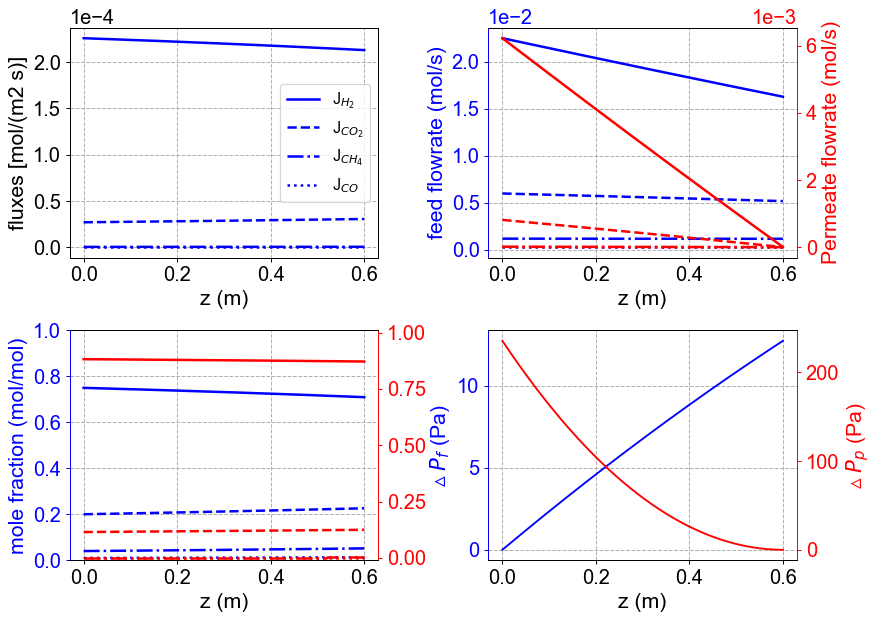

In [33]:
mem.PlotResults(component=['{H_2}','{CO_2}', '{CH_4}', '{CO}'])

In [34]:
F_r_tot = sum(res[-1, :n_component])
xr_i = res[-1, :n_component]/F_r_tot*100
print(np.round(xr_i, 4))


F_p_tot = sum(res[0, n_component:n_component*2])
xp_i = res[0, n_component:n_component*2]/F_p_tot*100
print(np.round(xp_i, 4))

[70.9403 22.603   5.1683  1.2884]
[8.82252e+01 1.15206e+01 1.93800e-01 6.04000e-02]


In [35]:
F_p_tot

0.007052662770184359

# Results

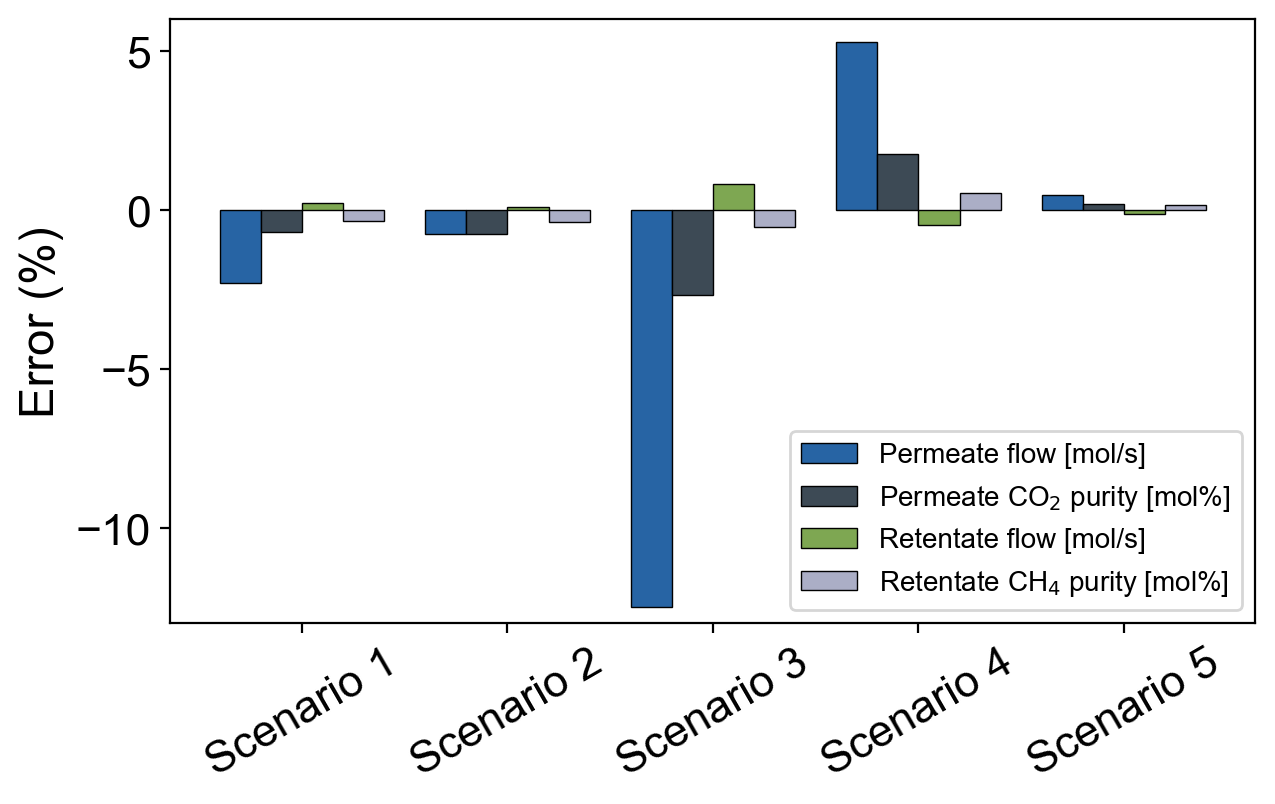

In [17]:
c= ['#2764A4', '#3D4A55', '#7EA752','#ABAEC6', ]
hatch_list = ['/', '\\', '|', '-']
# Sample data (replace with your actual metrics)
scenarios = ['Scenario 1', 'Scenario 2', 'Scenario 3', 'Scenario 4', 'Scenario 5']
metrics = ['Permeate flow [mol/s]', 'Permeate CO$_{2}$ purity [mol%]', 
           'Retentate flow [mol/s]', 'Retentate CH$_{4}$ purity [mol%]']

# Generate random data for your method and errors
your_results = np.array([[-2.28,	-0.67,	0.24,	-0.35],
                         [-0.76,	-0.76,	0.09	,-0.37],
                         [-12.48,	-2.66,	0.82	,-0.52],
                         [5.29,	1.78,	-0.45,	0.53],
                         [0.47	,0.18,	-0.11,	0.16]])

# Number of scenarios and metrics
num_scenarios = len(scenarios)
num_metrics = len(metrics)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(7, 4), dpi=200)

# Width of each bar and gap between scenarios
width = 0.2
gap = 0.

# Plot bars for each metric with error bars
for i, metric in enumerate(metrics):
    bars_your = your_results[:, i]

    ax.bar(np.arange(num_scenarios) + i * (width + gap), bars_your, width=width, label=f'{metric}',
           capsize=5, alpha=1, color = c[i], edgecolor = 'k', linewidth=0.5)

# Set the labels for each group
ax.set_xticks(np.arange(num_scenarios) + (width + gap) * (num_metrics - 1) / 2)
ax.set_xticklabels(scenarios, rotation=30)

# Add legend
ax.legend()

# Add labels and title
# ax.set_xlabel('Scenarios')
ax.set_ylabel('Error (%)')
# plt.title('Grouped Bar Plot - Your Method with Error Bars for Each Scenario')
plt.ylim(-13,6)
# plt.yscale('log')
# Show the plot
# plt.tight_layout()
plt.show()


In [48]:
val_data = pd.read_csv('../Data/pySembraneValidation.csv', index_col=0)
val_data

,Flow (mol/s)_cb,Flow (mol/s)_ps,Purity (mol%)_cb,Purity (mol%)_ps
s1,0.030000,0.029300,59.12,58.7256
s2,0.030000,0.029800,59.88,59.4229
s3,0.020000,0.017900,56.72,55.2115
s4,0.000045,0.000047,54.40,55.3704
s5,0.010000,0.007100,11.50,11.5206
s1,0.320000,0.320800,94.77,94.4371
s2,0.320000,0.320300,94.94,94.5866
s3,0.330000,0.332100,92.92,92.4353
s4,0.000422,0.000420,63.30,63.6349
s5,0.020000,0.023000,5.16,5.1683


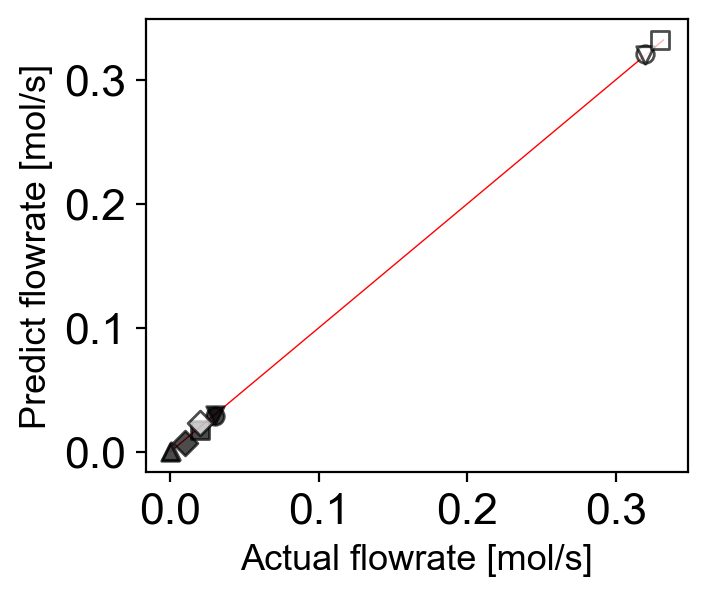

In [84]:
marker_list = ['o', 'v', 's', '^', 'D']
c_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
flow_min = val_data[['Flow (mol/s)_cb', 'Flow (mol/s)_ps']].min().min()
flow_max = val_data[['Flow (mol/s)_cb', 'Flow (mol/s)_ps']].max().max()
plt.figure(dpi=200, figsize=(3.5,3))
for i in range(len(marker_list)):
    plt.scatter(val_data['Flow (mol/s)_cb'][i+5],val_data['Flow (mol/s)_ps'][i+5], 
                marker=marker_list[i], c='white', edgecolors='k', s=40, alpha=0.7)
    plt.scatter(val_data['Flow (mol/s)_cb'][i],val_data['Flow (mol/s)_ps'][i], 
                marker=marker_list[i], c='k', s=40, alpha=0.7)
    # plt.scatter(val_data['Flow (mol/s)_cb'][i+5],val_data['Flow (mol/s)_ps'][i+5], 
    #             marker=marker_list[i], c='white', edgecolors='k', s=30, alpha=0.7)
plt.plot([flow_min, flow_max], [flow_min, flow_max], c='r', zorder=0, linewidth = 0.5)
plt.xlabel('Actual flowrate [mol/s]', fontsize=13)
plt.ylabel('Predict flowrate [mol/s]', fontsize=13)
plt.show()

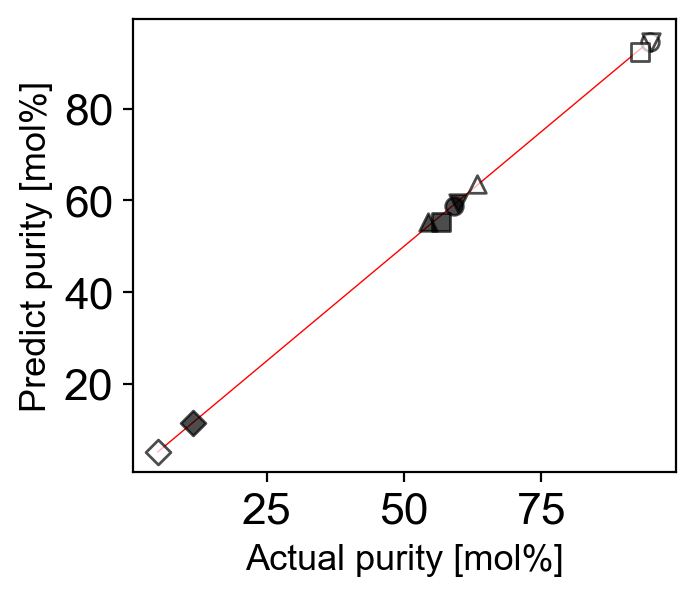

In [78]:
marker_list = ['o', 'v', 's', '^', 'D']
c_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
flow_min = val_data[['Purity (mol%)_cb', 'Purity (mol%)_ps']].min().min()
flow_max = val_data[['Purity (mol%)_cb', 'Purity (mol%)_ps']].max().max()
plt.figure(dpi=200, figsize=(3.5,3))
for i in range(len(marker_list)):
    plt.scatter(val_data['Purity (mol%)_cb'][i+5],val_data['Purity (mol%)_ps'][i+5], 
                marker=marker_list[i], c='white', edgecolors='k', s=40, alpha=0.7)
    plt.scatter(val_data['Purity (mol%)_cb'][i],val_data['Purity (mol%)_ps'][i], 
                marker=marker_list[i], c='k', s=40, alpha=0.7)
    # plt.scatter(val_data['Flow (mol/s)_cb'][i+5],val_data['Flow (mol/s)_ps'][i+5], 
    #             marker=marker_list[i], c='white', edgecolors='k', s=30, alpha=0.7)
plt.plot([flow_min, flow_max], [flow_min, flow_max], c='r', zorder=0, linewidth = 0.5)
plt.xlabel('Actual purity [mol%]', fontsize=13)
plt.ylabel('Predict purity [mol%]', fontsize=13)
plt.show()